In [ ]:
# prompt: how to install pycaret

!pip install pycaret


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 68.2 MB/s eta 0:00:00
   ━━━━━

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from pycaret.classification import *
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import seaborn as sns

# Load the datasets
labels_path = "/content/fake_LCICM_labels.csv"
bp_data_path = "/content/fake_LCICM_bp_data.csv"

labels_df = pd.read_csv(labels_path)
bp_data_df = pd.read_csv(bp_data_path)
bp_aggregated = bp_data_df.groupby("pat_id")["blood_pressure"].agg(["mean", "min", "max", "std"]).reset_index()

# Merge with labels
merged_df = labels_df.merge(bp_aggregated, on="pat_id", how="inner")


Logistic Regression: Train Accuracy = 0.8000, Test Accuracy = 0.8000
Random Forest: Train Accuracy = 0.9900, Test Accuracy = 0.8800
Gradient Boosting: Train Accuracy = 0.9800, Test Accuracy = 0.8800
Best Model: Random Forest with Test Accuracy: 0.8800
Final Best Model: Random Forest with Tuned Accuracy: 0.8800
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        32
           1       0.93      0.72      0.81        18

    accuracy                           0.88        50
   macro avg       0.89      0.85      0.86        50
weighted avg       0.89      0.88      0.88        50



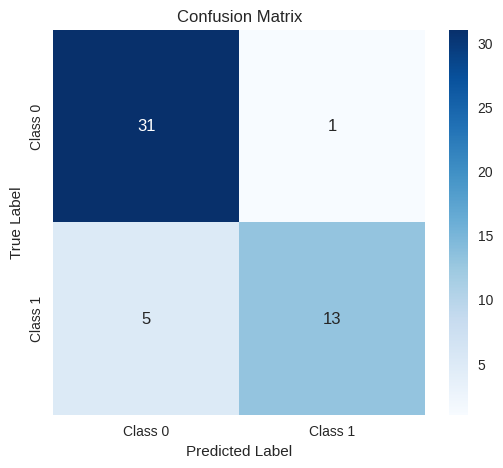

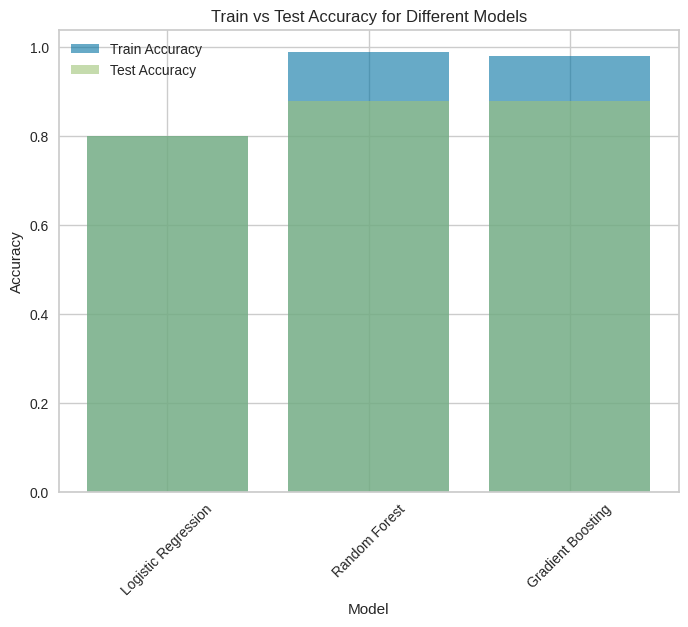

In [ ]:


X = merged_df[["mean", "min", "max", "std"]]
y = merged_df["label"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values (Imputation) only on training set, then apply to test set to prevent data leakage
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define models to compare
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate models
model_results = {}
train_accuracy = {}
test_accuracy = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_accuracy[name] = accuracy_score(y_train, y_train_pred)
    test_accuracy[name] = accuracy_score(y_test, y_test_pred)
    model_results[name] = test_accuracy[name]
    print(f"{name}: Train Accuracy = {train_accuracy[name]:.4f}, Test Accuracy = {test_accuracy[name]:.4f}")

# Select the best model
best_model_name = max(model_results, key=model_results.get)
best_model = models[best_model_name]

print(f"Best Model: {best_model_name} with Test Accuracy: {model_results[best_model_name]:.4f}")

# Hyperparameter tuning for best model
if best_model_name == "Logistic Regression":
    param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
    best_model = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=1000, random_state=42), param_grid, cv=5)
elif best_model_name == "Random Forest":
    param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
    best_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
elif best_model_name == "Gradient Boosting":
    param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
    best_model = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5)

best_model.fit(X_train, y_train)

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print results
print(f"Final Best Model: {best_model_name} with Tuned Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot Train vs Test Accuracy
plt.figure(figsize=(8, 6))
plt.bar(train_accuracy.keys(), train_accuracy.values(), alpha=0.6, label='Train Accuracy')
plt.bar(test_accuracy.keys(), test_accuracy.values(), alpha=0.6, label='Test Accuracy')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy for Different Models")
plt.legend()
plt.xticks(rotation=45)
plt.show()




Here instead of dropping the empty rows I performed Imputation as when too many rows are removed, the model has less data to learn from, leading to poor generalization.

I then also implemented Feature Scaling so that all features have a similar range and no feature values influence the process.
I also did all this for the training set so no data leakage happens for the testing set.

To improve the models performance I hypertuned the parameters to be able to find the right balance between overfitting and underfitting the model.
For Random Forest and gradient boosting, we see
 The training accuracy is higher than the testing accuracy, it’s a strong sign of overfitting.

Then tried training the data on many models in order to get the best performance.

Logistic Regression: Train Accuracy = 0.8000, Test Accuracy = 0.8000
Random Forest: Train Accuracy = 0.9350, Test Accuracy = 0.8800
Gradient Boosting: Train Accuracy = 0.9800, Test Accuracy = 0.8800
Best Model: Random Forest with Test Accuracy: 0.8800
Final Best Model: Random Forest with Tuned Accuracy: 0.8600
Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        32
           1       1.00      0.61      0.76        18

    accuracy                           0.86        50
   macro avg       0.91      0.81      0.83        50
weighted avg       0.89      0.86      0.85        50



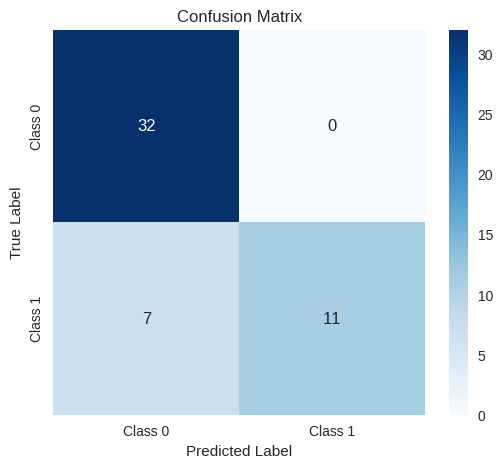

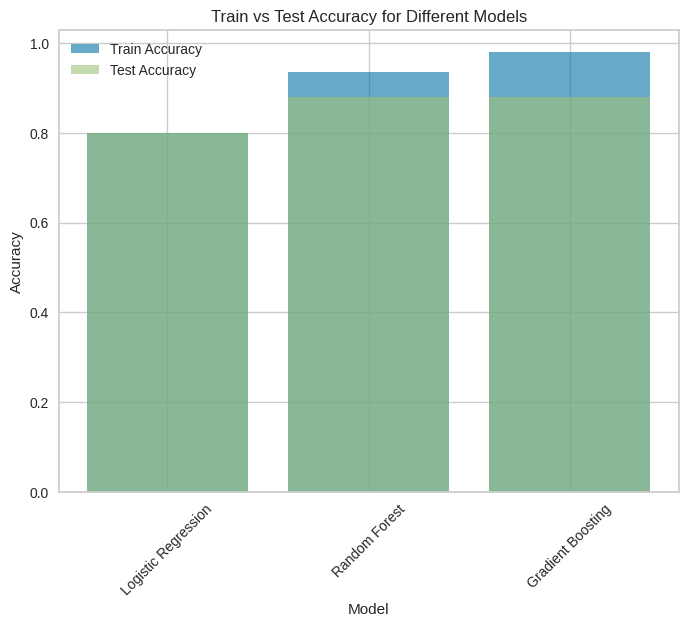

In [ ]:
# Define models to compare
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, min_samples_split=5, min_samples_leaf=2,),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}



# Train and evaluate models
model_results = {}
train_accuracy = {}
test_accuracy = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_accuracy[name] = accuracy_score(y_train, y_train_pred)
    test_accuracy[name] = accuracy_score(y_test, y_test_pred)
    model_results[name] = test_accuracy[name]
    print(f"{name}: Train Accuracy = {train_accuracy[name]:.4f}, Test Accuracy = {test_accuracy[name]:.4f}")

# Select the best model
best_model_name = max(model_results, key=model_results.get)
best_model = models[best_model_name]

print(f"Best Model: {best_model_name} with Test Accuracy: {model_results[best_model_name]:.4f}")

# Hyperparameter tuning for best model
if best_model_name == "Logistic Regression":
    param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
    best_model = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=1000, random_state=42), param_grid, cv=5)
elif best_model_name == "Random Forest":
   param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
   best_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
elif best_model_name == "Gradient Boosting":
    param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
    best_model = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5)

best_model.fit(X_train, y_train)

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print results
print(f"Final Best Model: {best_model_name} with Tuned Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot Train vs Test Accuracy
plt.figure(figsize=(8, 6))
plt.bar(train_accuracy.keys(), train_accuracy.values(), alpha=0.6, label='Train Accuracy')
plt.bar(test_accuracy.keys(), test_accuracy.values(), alpha=0.6, label='Test Accuracy')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy for Different Models")
plt.legend()
plt.xticks(rotation=45)
plt.show()


We see the Regularization we applied on Random Forest  has reduced the overfitting.


Class Distribution After Balancing:
label
0    133
1    133
Name: count, dtype: int64
Logistic Regression: Train Accuracy = 0.7444, Test Accuracy = 0.8000
Random Forest: Train Accuracy = 0.9549, Test Accuracy = 0.9000
Gradient Boosting: Train Accuracy = 0.9812, Test Accuracy = 0.8600
Best Model: Random Forest with Test Accuracy: 0.9000
Final Best Model: Random Forest with Tuned Accuracy: 0.8200
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.74      0.78      0.76        18

    accuracy                           0.82        50
   macro avg       0.80      0.81      0.81        50
weighted avg       0.82      0.82      0.82        50



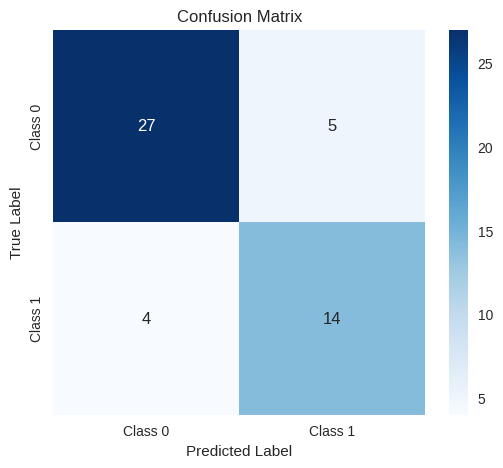

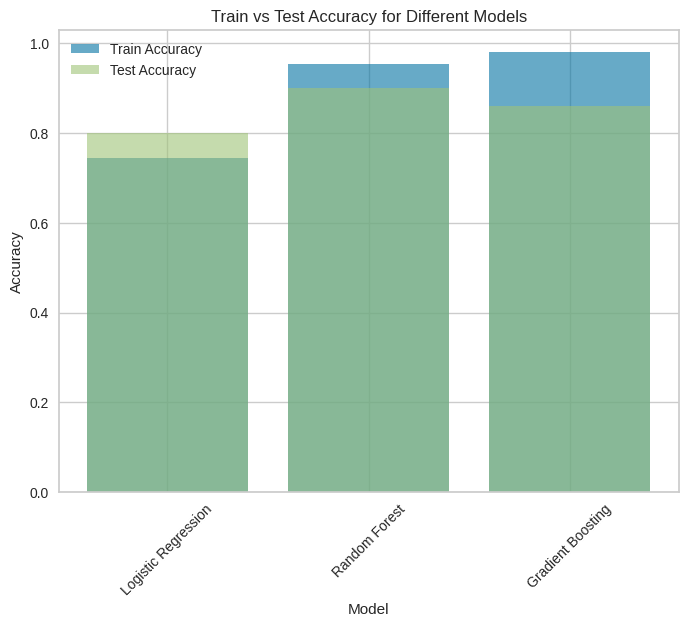

In [ ]:


# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
print("Class Distribution After Balancing:")
print(pd.Series(y_train).value_counts())

# Define models to compare
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=1000, random_state=42, penalty='l2', C=1.0),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Train and evaluate models
model_results = {}
train_accuracy = {}
test_accuracy = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_accuracy[name] = accuracy_score(y_train, y_train_pred)
    test_accuracy[name] = accuracy_score(y_test, y_test_pred)
    model_results[name] = test_accuracy[name]
    print(f"{name}: Train Accuracy = {train_accuracy[name]:.4f}, Test Accuracy = {test_accuracy[name]:.4f}")

# Select the best model
best_model_name = max(model_results, key=model_results.get)
best_model = models[best_model_name]

print(f"Best Model: {best_model_name} with Test Accuracy: {model_results[best_model_name]:.4f}")

# Hyperparameter tuning for best model
if best_model_name == "Logistic Regression":
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
    best_model = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=1000, random_state=42), param_grid, cv=5)
elif best_model_name == "Random Forest":
    param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
    best_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
elif best_model_name == "Gradient Boosting":
    param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [2, 3, 5]}
    best_model = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5)

best_model.fit(X_train, y_train)

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print results
print(f"Final Best Model: {best_model_name} with Tuned Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot Train vs Test Accuracy
plt.figure(figsize=(8, 6))
plt.bar(train_accuracy.keys(), train_accuracy.values(), alpha=0.6, label='Train Accuracy')
plt.bar(test_accuracy.keys(), test_accuracy.values(), alpha=0.6, label='Test Accuracy')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy for Different Models")
plt.legend()
plt.xticks(rotation=45)
plt.show()


 Used smote, which is data balancing that Helps prevent the model from being biased toward the majority class.

[LightGBM] [Info] Number of positive: 133, number of negative: 133
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 266, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

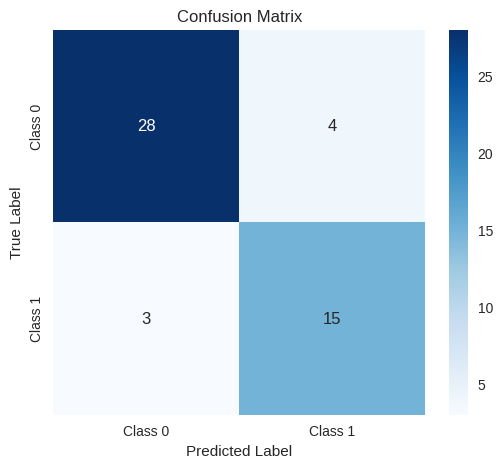

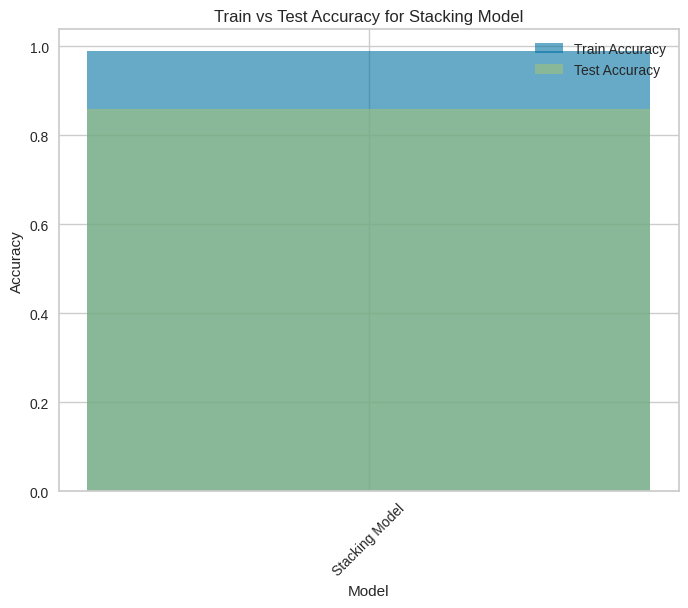

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns


# Define base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

# Define stacking model with Logistic Regression as meta-model
stacked_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(), cv=5)

# Train the stacking model
stacked_model.fit(X_train, y_train)

# Make predictions with the stacking model
y_pred = stacked_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print results
print(f"Final Stacking Model Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot Train vs Test Accuracy
plt.figure(figsize=(8, 6))
plt.bar(["Stacking Model"], [stacked_model.score(X_train, y_train)], alpha=0.6, label='Train Accuracy')
plt.bar(["Stacking Model"], [accuracy], alpha=0.6, label='Test Accuracy')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy for Stacking Model")
plt.legend()
plt.xticks(rotation=45)
plt.show()


Tried Stacking ->uses multiple models to improve prediction robustness. which made it worse so went back to try increasing the cross validation

Class Distribution After Balancing:
label
0    133
1    133
Name: count, dtype: int64
Logistic Regression: Train Accuracy = 0.7444, Test Accuracy = 0.8000
Random Forest: Train Accuracy = 0.9549, Test Accuracy = 0.9000
Gradient Boosting: Train Accuracy = 0.9812, Test Accuracy = 0.8600
Best Model: Random Forest with Test Accuracy: 0.9000
Final Best Model: Random Forest with Tuned Accuracy: 0.8200
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85        32
           1       0.71      0.83      0.77        18

    accuracy                           0.82        50
   macro avg       0.81      0.82      0.81        50
weighted avg       0.83      0.82      0.82        50



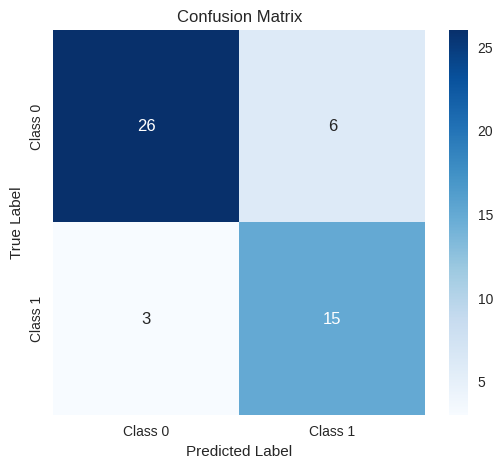

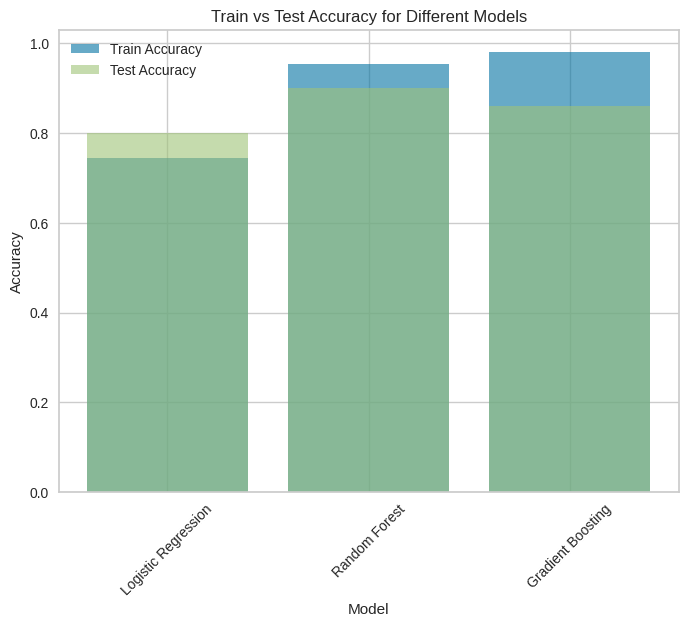

In [ ]:


smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Check class distribution after SMOTE
print("Class Distribution After Balancing:")
print(pd.Series(y_train).value_counts())

# Define models to compare
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', max_iter=1000, random_state=42, penalty='l2', C=1.0),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Train and evaluate models
model_results = {}
train_accuracy = {}
test_accuracy = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_accuracy[name] = accuracy_score(y_train, y_train_pred)
    test_accuracy[name] = accuracy_score(y_test, y_test_pred)
    model_results[name] = test_accuracy[name]
    print(f"{name}: Train Accuracy = {train_accuracy[name]:.4f}, Test Accuracy = {test_accuracy[name]:.4f}")

# Select the best model
best_model_name = max(model_results, key=model_results.get)
best_model = models[best_model_name]

print(f"Best Model: {best_model_name} with Test Accuracy: {model_results[best_model_name]:.4f}")

# Hyperparameter tuning for best model
if best_model_name == "Logistic Regression":
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
    best_model = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=1000, random_state=42), param_grid, cv=10)
elif best_model_name == "Random Forest":
    param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
    best_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=10)
elif best_model_name == "Gradient Boosting":
    param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [2, 3, 5]}
    best_model = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=10)

best_model.fit(X_train, y_train)

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print results
print(f"Final Best Model: {best_model_name} with Tuned Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot Train vs Test Accuracy
plt.figure(figsize=(8, 6))
plt.bar(train_accuracy.keys(), train_accuracy.values(), alpha=0.6, label='Train Accuracy')
plt.bar(test_accuracy.keys(), test_accuracy.values(), alpha=0.6, label='Test Accuracy')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy for Different Models")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [ ]:
data = merged_df_clean.copy()

# Setup PyCaret environment
clf = setup(data, target="label", session_id=42)

# Train and compare models
best_model = compare_models()

# Finalize the best model
final_model = finalize_model(best_model)

# Evaluate the best model
evaluate_model(final_model)

# Predict on new data
predictions = predict_model(final_model)


,Description,Value
0,Session id,42
1,Target,label
2,Target type,Binary
3,Original data shape,"(212, 6)"
4,Transformed data shape,"(212, 6)"
5,Transformed train set shape,"(148, 6)"
6,Transformed test set shape,"(64, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.8280
dt,Decision Tree Classifier,0.9933,0.9950,1.0000,0.9833,0.9909,0.9857,0.9866,0.0270
rf,Random Forest Classifier,0.9933,1.0000,1.0000,0.9833,0.9909,0.9857,0.9866,0.2720
ada,Ada Boost Classifier,0.9933,0.9950,1.0000,0.9833,0.9909,0.9857,0.9866,0.0440
gbc,Gradient Boosting Classifier,0.9933,0.9950,1.0000,0.9833,0.9909,0.9857,0.9866,0.0820
xgboost,Extreme Gradient Boosting,0.9933,0.9950,1.0000,0.9833,0.9909,0.9857,0.9866,0.0500
lightgbm,Light Gradient Boosting Machine,0.9933,0.9950,1.0000,0.9833,0.9909,0.9857,0.9866,0.0710
et,Extra Trees Classifier,0.9867,1.0000,0.9600,1.0000,0.9778,0.9684,0.9706,0.1420
knn,K Neighbors Classifier,0.9729,1.0000,0.9200,1.0000,0.9528,0.9346,0.9408,0.0400
qda,Quadratic Discriminant Analysis,0.9462,0.9920,0.8800,0.9583,0.9104,0.8729,0.8807,0.0720


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


I also just tried PyCaret an AutoML model to find that the Logistic Regression model performs the best.